# Common Libraries

In [1]:
import os
import cv2
import random
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import time
from imutils import paths

# from skimage.measure import shannon_entropy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier

# Image Files

In [42]:
files = glob.glob('/content/images/*.png')
files = [file_ for file_ in files]
files = np.array(files)

In [43]:
files

array(['/content/images/test_2.png', '/content/images/test_1.png'],
      dtype='<U26')

(192, 168, 3)


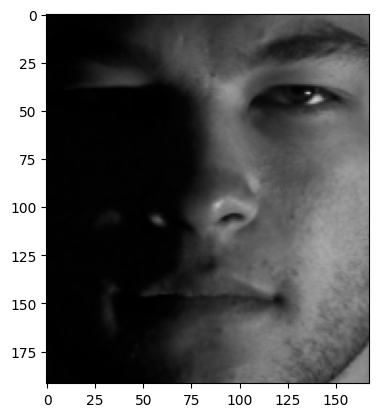

In [56]:
image1 = cv2.imread(files[0])
print(image1.shape)
plt.imshow(image1)
plt.show()

(192, 168, 3)


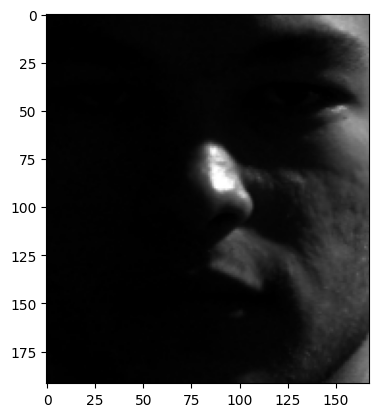

In [57]:
image2 = cv2.imread(files[1])
print(image2.shape)
plt.imshow(image2)
plt.show()

# Local Binary Pattern

## Pre processing

In [18]:
def process_image(path):
  # RGB input -------------------------------------------------------------------
  img_org = image.load_img(path,color_mode='rgb')
  img_org = tf.image.resize(img_org, (55,47))
  img_org = image.img_to_array(img_org)

  return img_org

In [19]:
def py_lbp(Im):
    # Local Binary Patterns
    rows=Im.shape[0]
    cols=Im.shape[1]
    L=np.zeros((rows,cols),dtype='uint8')
    I=np.zeros((rows+2,cols+2),dtype='uint8')

    #Zero padding
    I[1:rows+1,1:cols+1]=Im

    #Select center pixel
    for i in range(1,rows+1):
        for j in range(1,cols+1):
            #Compute LBP transform
            L[i-1,j-1]=\
            ( I[i-1,j]  >= I[i,j] )*1+\
            ( I[i-1,j+1]>= I[i,j] )*2+\
            ( I[i,j+1]  >= I[i,j] )*4+\
            ( I[i+1,j+1]>= I[i,j] )*8+\
            ( I[i+1,j]  >= I[i,j] )*16+\
            ( I[i+1,j-1]>= I[i,j] )*32+\
            ( I[i,j-1]  >= I[i,j] )*64+\
            ( I[i-1,j-1]>= I[i,j] )*128;

    return L

def tf_lbp(Im):
    paddings = tf.constant([[0,0],[1, 1], [1, 1]])
    Im=tf.pad(Im, paddings,"CONSTANT")
    M=Im.shape [1]
    N=Im.shape [2]

    # Select the pixels of masks in the form of matrices
    y00=Im[:,0:M-2, 0:N-2]
    y01=Im[:,0:M-2, 1:N-1]
    y02=Im[:,0:M-2, 2:N  ]
    #
    y10=Im[:,1:M-1, 0:N-2]
    y11=Im[:,1:M-1, 1:N-1]
    y12=Im[:,1:M-1, 2:N  ]
    #
    y20=Im[:,2:M, 0:N-2]
    y21=Im[:,2:M, 1:N-1]
    y22=Im[:,2:M, 2:N ]


    # y00  y01  y02
    # y10  y11  y12
    # y20  y21  y22

    # Comparisons
    # 1 -----------------------------------------
    g=tf.greater_equal(y01,y11)
    z=tf.multiply(tf.cast(g,dtype='uint8'),
                  tf.constant(1,dtype='uint8') )
    # 2 -----------------------------------------
    g=tf.greater_equal(y02,y11)
    tmp=tf.multiply(tf.cast(g,dtype='uint8'),
                    tf.constant(2,dtype='uint8') )
    z =tf.add(z,tmp)
    # 3 -----------------------------------------
    g=tf.greater_equal(y12,y11)
    tmp=tf.multiply(tf.cast(g,dtype='uint8'),
                    tf.constant(4,dtype='uint8') )
    z =tf.add(z,tmp)
    # 4 -----------------------------------------
    g=tf.greater_equal(y22,y11)
    tmp=tf.multiply(tf.cast(g,dtype='uint8'),
                    tf.constant(8,dtype='uint8') )
    z =tf.add(z,tmp)
    # 5 -----------------------------------------
    g=tf.greater_equal(y21,y11)
    tmp=tf.multiply(tf.cast(g,dtype='uint8'),
                    tf.constant(16,dtype='uint8') )
    z =tf.add(z,tmp)
    # 6 -----------------------------------------
    g=tf.greater_equal(y20,y11)
    tmp=tf.multiply(tf.cast(g,dtype='uint8'),
                    tf.constant(32,dtype='uint8') )
    z =tf.add(z,tmp)
    # 7 -----------------------------------------
    g=tf.greater_equal(y10,y11)
    tmp=tf.multiply(tf.cast(g,dtype='uint8'),
                    tf.constant(64,dtype='uint8') )
    z =tf.add(z,tmp)
    # 8 -----------------------------------------
    g=tf.greater_equal(y00,y11)
    tmp=tf.multiply(tf.cast(g,dtype='uint8'),
                    tf.constant(128,dtype='uint8') )
    z =tf.add(z,tmp)
    #--------------------------------------------
    return tf.cast(z,dtype=tf.uint8)

Text(0.5, 1.0, 'LBP output')

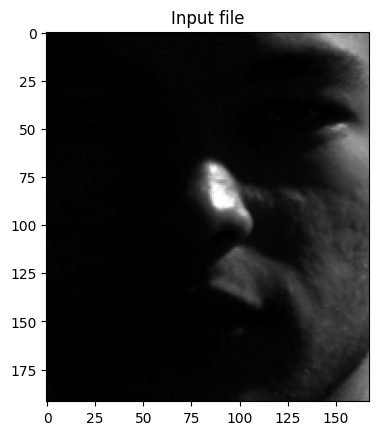

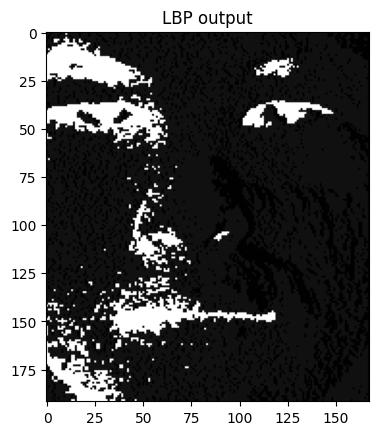

In [45]:
# Extract to 1 channel (Grayscale) LBP Image
path = files[1]

# RGB input -------------------------------------------------------------------
img_org =image.load_img(path,color_mode='grayscale')
img_org=image.img_to_array(img_org)
[Rows,Cols,nChannel]=img_org.shape

# Allocation for the rgb output
lbp_rgb=img_org.copy()
lbp_rgb = tf_lbp(img_org)


# Show input and output images-------------------------------------------------
plt.figure(1)
plt.imshow(img_org,cmap='gray')
plt.title('Input file')
plt.figure(2)
plt.imshow(lbp_rgb,cmap='gray')
plt.title('LBP output')

Text(0.5, 1.0, 'RGB output')

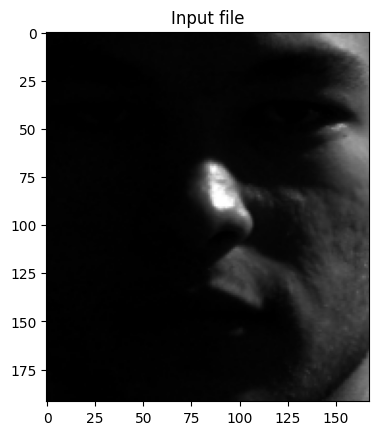

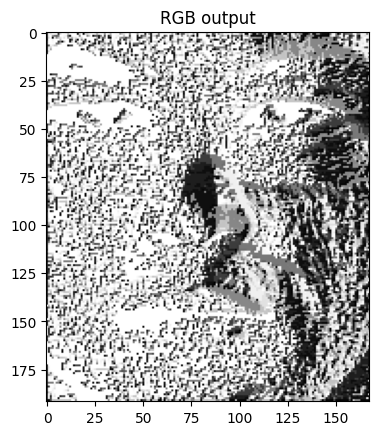

In [46]:
# Extract to 3 channel (RGB) LBP Image
path = files[1]

# RGB input -------------------------------------------------------------------
img_org =image.load_img(path,color_mode='rgb')
img_org=image.img_to_array(img_org)
[Rows,Cols,nChannel]=img_org.shape

# Allocation for the rgb output
lbp_rgb=img_org.copy()
lbp_rgb[:,:,0] = tf_lbp(img_org[:,:,0].reshape(1,Rows,Cols).astype('uint8')).numpy()
lbp_rgb[:,:,1] = tf_lbp(img_org[:,:,1].reshape(1,Rows,Cols).astype('uint8')).numpy()
lbp_rgb[:,:,2] = tf_lbp(img_org[:,:,2].reshape(1,Rows,Cols).astype('uint8')).numpy()


# Show input and output images-------------------------------------------------
plt.figure(1)
plt.imshow(img_org.astype('uint8'))
plt.title('Input file')
plt.figure(2)
plt.imshow(lbp_rgb.astype('uint8') )
plt.title('RGB output')

# Histogram of Oriented Gradients (HOG)

In [31]:
from skimage.feature import hog

In [40]:
def hog_features(img, show_hog=False):
    img = cv2.imread(img)
    # flatten image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = np.array(0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2])
    # get HOG features from greyscale image
    hog_features, hog_image = hog(grey_image, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    if show_hog:
        plt.imshow(hog_image, cmap="gray")
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

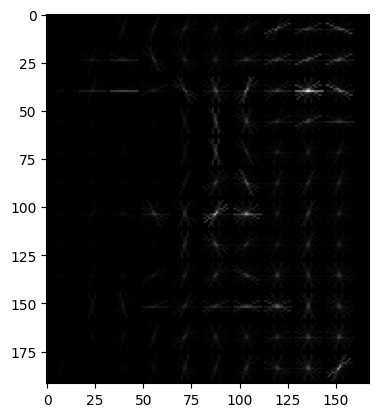

In [48]:
res = hog_features(files[0], True)

# DeepID

## Libraries for DeepID

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D,
    Activation,
    Input,
    Add,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    )

## DeepID Feature Extraction

In [50]:
def deepid_keras_model():

    myInput = Input(shape=(55, 47, 3))

    x = Conv2D(20, (4, 4), name='Conv1', activation='relu', input_shape=(55, 47, 3))(myInput)
    x = MaxPooling2D(pool_size=2, strides=2, name='Pool1')(x)
    x = Dropout(rate=0.99, name='D1')(x)

    x = Conv2D(40, (3, 3), name='Conv2', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, name='Pool2')(x)
    x = Dropout(rate=0.99, name='D2')(x)

    x = Conv2D(60, (3, 3), name='Conv3', activation='relu')(x)
    x = MaxPooling2D(pool_size=2, strides=2, name='Pool3')(x)
    x = Dropout(rate=0.99, name='D3')(x)

    #--------------------------------------

    x1 = Flatten()(x)
    fc11 = Dense(160, name = 'fc11')(x1)

    #--------------------------------------

    x2 = Conv2D(80, (2, 2), name='Conv4', activation='relu')(x)
    x2 = Flatten()(x2)
    fc12 = Dense(160, name = 'fc12')(x2)

    #--------------------------------------

    y = Add()([fc11, fc12])
    y = Activation('relu', name = 'deepid')(y)

    model = Model(inputs=[myInput], outputs=y)

    return model

In [51]:
deepid_model = deepid_keras_model()
deepid_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 55, 47, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 52, 44, 20)     │            980 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool1 (MaxPooling2D)      │ (None, 26, 22, 20)     │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ D1 (Dropout)              │ (None, 26, 22, 20)     │              0 │ Pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 24, 20, 40)     │          7,240 │ D1[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool2 (MaxPooling2D)      │ (None, 12, 10, 40)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ D2 (Dropout)              │ (None, 12, 10, 40)     │              0 │ Pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv3 (Conv2D)            │ (None, 10, 8, 60)      │         21,660 │ D2[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Pool3 (MaxPooling2D)      │ (None, 5, 4, 60)       │              0 │ Conv3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ D3 (Dropout)              │ (None, 5, 4, 60)       │              0 │ Pool3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv4 (Conv2D)            │ (None, 4, 3, 80)       │         19,280 │ D3[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1200)           │              0 │ D3[0][0]               │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 960)            │              0 │ Conv4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc11 (Dense)              │ (None, 160)            │        192,160 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc12 (Dense)              │ (None, 160)            │        153,760 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 160)            │              0 │ fc11[0][0], fc12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deepid (Activation)       │ (None, 160)            │              0 │ add[0][0]              │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 395,080 (1.51 MB)

 Trainable params: 395,080 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Pretrain model
weights_path = '/content/deepid_keras_weights.h5'
deepid_model.load_weights(weights_path)

In [53]:
# Image processing
def process_image(path):
  # RGB input -------------------------------------------------------------------
  img_org = image.load_img(path,color_mode='rgb')
  img_org = tf.image.resize(img_org, (55,47))
  img_org = image.img_to_array(img_org)

  return img_org

In [54]:
def extract_features(image_folder):
  embeddings = []
  i = 0
  for image_path in image_folder:
    if image_path is not None:
      img = process_image(image_path)
      img = tf.expand_dims(img,0)
      embedding = deepid_model.predict(img)
      if embedding is not None:
        embeddings.append(embedding)
        i+=1

  print("counts:",i)
  return embeddings

In [55]:
extract_features(files)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
counts: 2


[array([[    0.      ,     0.      ,  1872.6047  ,  5672.368   ,
           854.86285 ,     0.      ,  3020.9443  ,  5011.4653  ,
             0.      ,     0.      ,  1229.0986  ,  3062.546   ,
          5131.0317  ,     0.      ,  1589.0228  ,     0.      ,
             0.      ,     0.      ,  1323.5115  ,     0.      ,
          3204.5972  ,     0.      ,     0.      ,  1836.8958  ,
             0.      ,  4526.206   ,     0.      ,     0.      ,
             0.      ,     0.      ,     0.      ,  3425.261   ,
          4264.789   ,     0.      ,  5923.3164  ,     0.      ,
          5233.851   ,     0.      ,  1400.388   ,  8352.948   ,
             0.      ,  4690.173   ,     0.      ,     0.      ,
          4894.048   ,     0.      ,     0.      ,     0.      ,
             0.      ,     0.      ,  1425.261   ,     0.      ,
          2806.305   ,  7293.052   ,   322.72363 ,    62.677734,
             0.      ,     0.      ,     0.      ,  3717.2124  ,
             0.      ,   